In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score


df_not_outliers = pd.read_csv('../intermedio_sin_outliers.csv')

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])
y_sin_outliers = df_not_outliers['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y_sin_outliers, test_size=0.2, random_state=42
)


In [2]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 01m 45s]
val_mae: 11523.8232421875

Best val_mae So Far: 2251.33251953125
Total elapsed time: 00h 16m 37s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model2(best_hp3)
history2 = model3.fit(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_data=(X_test_sin_outliers, y_test_sin_outliers),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 15914.3691 - mae: 15906.6055 - r2: -2.7187 - rmse: 19362.4785 - val_loss: 3897.9070 - val_mae: 3879.9954 - val_r2: 0.7396 - val_rmse: 5456.3633
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4958.9019 - mae: 4940.5127 - r2: 0.6179 - rmse: 6532.2544 - val_loss: 3550.3745 - val_mae: 3530.0776 - val_r2: 0.7904 - val_rmse: 4895.2295
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4504.0171 - mae: 4483.1123 - r2: 0.6632 - rmse: 6087.7495 - val_loss: 3139.6560 - val_mae: 3117.1116 - val_r2: 0.8279 - val_rmse: 4434.9751
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3996.3237 - mae: 3973.1689 - r2: 0.7298 - rmse: 5456.4634 - val_loss: 2816.2100 - val_mae: 2791.3508 - val_r2: 0.8561 - val_rmse: 4055.7798
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3709.4946 - mae: 3684.3887 - r2: 0.7624 - rmse: 5080.8735 - val_loss: 2709.2903 - val_mae: 2683.1570 - val_r2: 0.8614 - val_rmse: 3979.9

In [4]:
print (best_hp3.values)
print (best_hp3)

{'units_1': 160, 'dropout_1': 0.2, 'units_2': 112, 'dropout_2': 0.30000000000000004, 'units_3': 48, 'lr': 0.01}


In [5]:
y_pred = model3.predict(X_test_sin_outliers).flatten()

mae = mean_absolute_error(y_test_sin_outliers, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred))
r2 = r2_score(y_test_sin_outliers, y_pred)
mape = np.mean(np.abs((y_test_sin_outliers - y_pred) / y_test_sin_outliers)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")



106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

--- MÉTRICAS ---
MAE: $2,334
RMSE: $3,533
R2: 0.891
MAPE: 10.55%


In [6]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [7]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 01m 40s]
val_mae: 3163.619140625

Best val_mae So Far: 3155.09130859375
Total elapsed time: 00h 16m 24s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- MÉTRICAS ---
MAE: $3,095
RMSE: $4,773
R2: 0.798
MAPE: 12.83%


In [10]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)
print(best_hp.values)
print(best_hp)

c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 18864.5410 - mae: 18860.1602 - r2: -3.4780 - rmse: 22103.6973 - val_loss: 4370.7241 - val_mae: 4357.5073 - val_r2: 0.6694 - val_rmse: 6107.0034
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5760.1802 - mae: 5746.6113 - r2: 0.4562 - rmse: 7725.7676 - val_loss: 3761.9336 - val_mae: 3747.6206 - val_r2: 0.7479 - val_rmse: 5332.9292
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5104.5303 - mae: 5090.0977 - r2: 0.5536 - rmse: 6976.4131 - val_loss: 3501.0261 - val_mae: 3486.1450 - val_r2: 0.7674 - val_rmse: 5122.7358
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4799.1719 - mae: 4784.0762 - r2: 0.6073 - rmse: 6614.3340 - val_loss: 3518.0691 - val_mae: 3502.2971 - val_r2: 0.7696 - val_rmse: 5097.8369
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4704.4917 - mae: 4688.7134 - r2: 0.6186 - rmse: 6560.9731 - val_loss: 3456.6489 - val_mae: 3440.4128 - val_r2: 0.7575 - val_rmse: 5230.4

In [21]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [22]:
# Modelo
def build_model3(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner3 = kt.RandomSearch(
    build_model3,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner3.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner3.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 01m 13s]
val_mae: 14352.6884765625

Best val_mae So Far: 2592.94482421875
Total elapsed time: 00h 11m 12s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model3(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 19614.7109 - mae: 19612.2383 - r2: -3.7715 - rmse: 22641.3203 - val_loss: 4451.4888 - val_mae: 4441.8618 - val_r2: 0.6961 - val_rmse: 5893.8369
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4895.9429 - mae: 4885.5454 - r2: 0.6247 - rmse: 6436.8115 - val_loss: 3357.4365 - val_mae: 3345.2393 - val_r2: 0.7982 - val_rmse: 4802.9639
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4240.2197 - mae: 4227.8447 - r2: 0.6977 - rmse: 5739.9155 - val_loss: 3123.5107 - val_mae: 3110.9226 - val_r2: 0.8166 - val_rmse: 4579.1191
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4035.9919 - mae: 4023.2012 - r2: 0.7226 - rmse: 5457.1714 - val_loss: 3141.6409 - val_mae: 3128.4351 - val_r2: 0.8201 - val_rmse: 4535.3057
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4022.8386 - mae: 4009.4971 - r2: 0.7188 - rmse: 5574.7500 - val_loss: 2910.2466 - val_mae: 2896.4912 - val_r2: 0.8424 - val_rmse: 4244.3

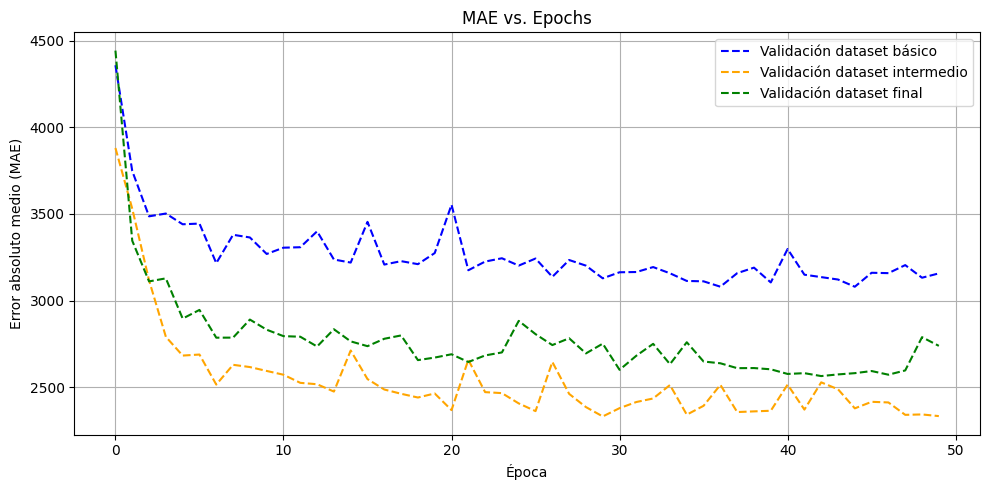

In [30]:
plt.figure(figsize=(10, 5))
#plt.plot(history1.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history1.history['val_mae'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history2.history['mae'], label='Entrenamiento dataset intermedio',color='Orange')
plt.plot(history2.history['val_mae'], label='Validación dataset intermedio',color='Orange', linestyle='--')
#plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


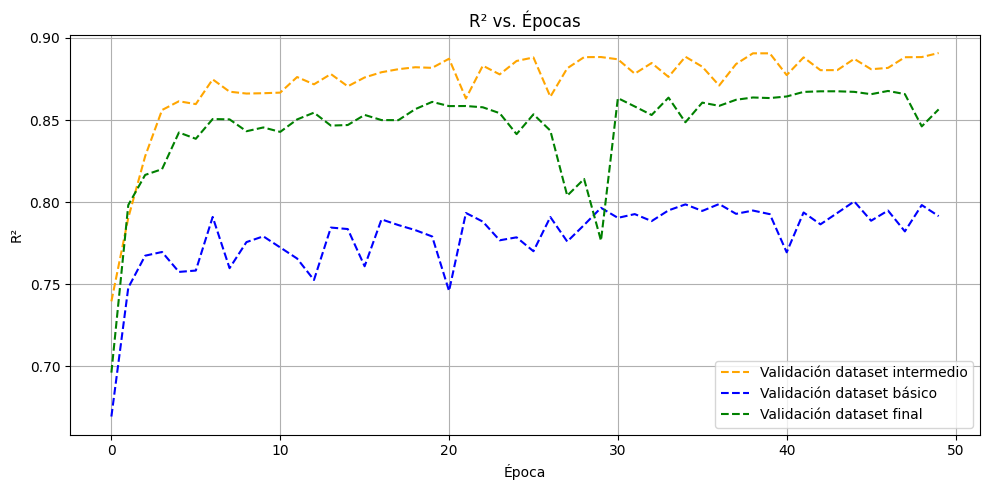

In [32]:
plt.figure(figsize=(10, 5))
#plt.plot(history2.history['r2'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history2.history['val_r2'], label='Validación dataset intermedio', linestyle='--', color='orange')
#plt.plot(history1.history['r2'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history1.history['val_r2'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history3.history['r2'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_r2'], label='Validación dataset final', linestyle='--', color='green')
plt.title('R² vs. Épocas')
plt.xlabel('Época')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
 

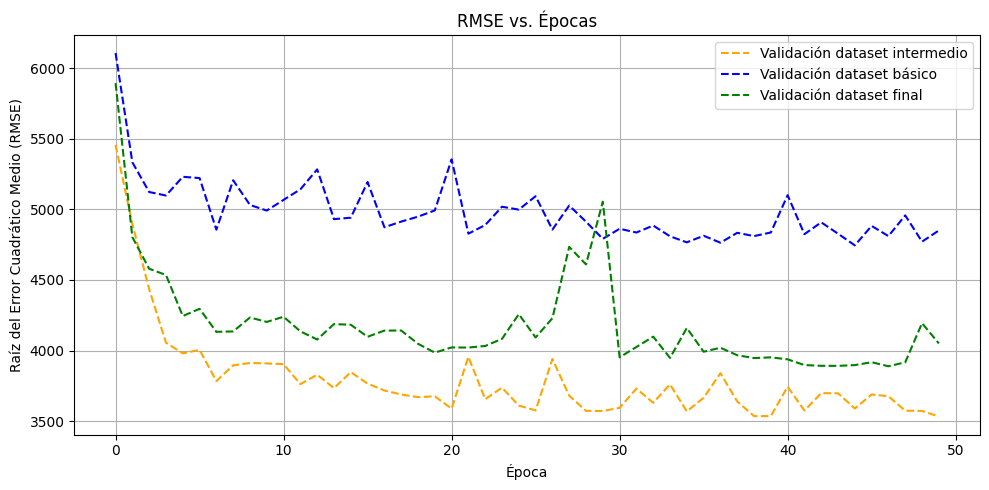

In [33]:
plt.figure(figsize=(10, 5))
#plt.plot(history2.history['rmse'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history2.history['val_rmse'], label='Validación dataset intermedio', linestyle='--', color='orange')
#plt.plot(history1.history['rmse'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history1.history['val_rmse'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history3.history['rmse'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_rmse'], label='Validación dataset final', linestyle='--', color='green')
plt.title('RMSE vs. Épocas')
plt.xlabel('Época')
plt.ylabel('Raíz del Error Cuadrático Medio (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
from tabulate import tabulate
import pandas as pd
import numpy as np

# Supone que ya tenés mae, rmse, r2, history1, history2, history3 definidos

metrics = {
    'Modelo': ['Básico', 'Intermedio', 'Final'],
    'MAE': [
        np.mean(history1.history['mae']),
        np.mean(history2.history['mae']),
        np.mean(history3.history['mae']),
    ],
    'RMSE': [
        np.mean(history1.history['rmse']),
        np.mean(history2.history['rmse']),
        np.mean(history3.history['rmse']),
    ],
    'R²': [
        np.mean(history1.history['r2']),
        np.mean(history2.history['r2']),
        np.mean(history3.history['r2']),
    ],
}

df_metrics = pd.DataFrame(metrics)

# Imprimir en formato tabla bonito
print(tabulate(df_metrics, headers='keys', tablefmt='fancy_grid', showindex=False))



╒════════════╤═════════╤═════════╤══════════╕
│ Modelo     │     MAE │    RMSE │       R² │
╞════════════╪═════════╪═════════╪══════════╡
│ Básico     │ 4277.44 │ 6107.93 │ 0.646845 │
├────────────┼─────────┼─────────┼──────────┤
│ Intermedio │ 3277.66 │ 4597.69 │ 0.790706 │
├────────────┼─────────┼─────────┼──────────┤
│ Final      │ 3915.97 │ 5427.19 │ 0.708219 │
╘════════════╧═════════╧═════════╧══════════╛
